In [1]:
import pip

package_names = ['awswrangler'] 
pip.main(['install'] + package_names + ['--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


0

In [2]:
# Nativos
from dateutil.relativedelta import relativedelta
from time import gmtime, strftime
from datetime import datetime
import random as rn
import joblib
import json
import sys
import os
import gc

#nube
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
import awswrangler as wr
import sagemaker
import boto3

#calculo
import pandas as pd
import numpy as np
import scipy

#grafico
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()
# MODELS
#from lightgbm import LGBMClassifier

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)
#import scorecardpy as sc
#from utils import *
#from graphs import *

SEED = 29082013
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

#from utils import *
#from modeler import *
#subfolder = "data"
# os.listdir(subfolder)

In [3]:
# imports
from UTILITARIO_CODE.utils import targets
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri
import awswrangler as wr
import pandas as pd
import sagemaker
import boto3

proyecto = 'propension'
normal = [1]
target = targets[7]
clasif = 'normal' if len(normal) == 1 else 'all'

sess = sagemaker.session.Session()
bucket = sess.default_bucket() 
now = datetime.now()
role = sagemaker.get_execution_role()   ## levantamiento de roles
s3 = boto3.resource('s3')
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

print("bucket: ", bucket)
print("region: ", region)
print("now: ", now)

bucket, region, target, clasif

bucket:  sagemaker-us-east-1-058528764918
region:  us-east-1
now:  2021-08-02 18:49:01.567657


('sagemaker-us-east-1-058528764918',
 'us-east-1',
 'target_desembolso_f2m_mayor_30_menor_180',
 'normal')

In [4]:
sufijo = '{}_clasif_{}'.format(target.lower(), clasif)
sufijo

'target_desembolso_f2m_mayor_30_menor_180_clasif_normal'

In [5]:
from UTILITARIO_CODE.utils import dicc_seleccionadas, dicc_bests_models

seleccionadas = dicc_seleccionadas[sufijo]
print(len(seleccionadas))
print(seleccionadas)

////////////////////////////////////////////////// 

path_container_input:  /opt/ml/processing/input
path_container_output:  /opt/ml/processing/output
path_container_utils:  /opt/ml/processing/input/utils
path_container_universo:  /opt/ml/processing/input/HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
15
['entidad_cnt_prom_u9m', 'monto_pagado_u6m', 'monto_adquirido_u6m', 'nro_entidades_termino_prestamo_u9m', 'saldo_col_direct_vig_competencia', 'sum_saldo_ajustado_promedio_u9m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u3m', 'nro_entidades_ya_no_tiene_saldo_ajustado_u9m', 'ultima_variacion_saldo_ajustado', 'tendencia_saldo_col_direct_vencido', 'saldo_reactiva', 'percent_promedio_col_direct_ibk_u3m', 'saldo_col_direct_vig_banco_no_ibk', 'monto_deuda_sf_prom_u9m', 'tendencia_max_dias_atraso_coloc_directas']


In [6]:
model_code =  dicc_bests_models[sufijo]
model_code

'xgboost-vpc-7-210727-1702-011-63804022'

In [8]:
model_code = 'xgboost-vpc-7-210731-0433-029-54f28ca2'
model_code

'xgboost-vpc-7-210731-0433-029-54f28ca2'

### Load data

In [9]:
uri_output = 's3://{}/vpc/{}/output'.format(bucket, proyecto)
uri_segui = 's3://{}/vpc/{}/seguimiento'.format(bucket, proyecto)
uri_predict = uri_output.replace('output', 'prediccion')

print(uri_predict)
print(uri_segui)

s3://sagemaker-us-east-1-058528764918/vpc/propension/prediccion
s3://sagemaker-us-east-1-058528764918/vpc/propension/seguimiento


** OJO: modificar esta parte en caso de cambios de periodos**

In [10]:
uri_validation_202103 = uri_segui + '/202103_{}.csv'.format(sufijo)
uri_validation_202104 = uri_segui + '/202104_{}.csv'.format(sufijo)
uri_validation_202105 = uri_segui + '/202105_{}.csv'.format(sufijo)
uri_validation_202106 = uri_segui + '/202106_{}.csv'.format(sufijo)

print(uri_validation_202103)
print(uri_validation_202104)
print(uri_validation_202105)
print(uri_validation_202106)

s3://sagemaker-us-east-1-058528764918/vpc/propension/seguimiento/202103_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/seguimiento/202104_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/seguimiento/202105_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/seguimiento/202106_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv


In [12]:
_2003 = wr.s3.read_csv(
    uri_validation_202103, 
    sep=',',
)
_2003.head()

,cod_sbs_val,target_desembolso_f2m_mayor_30_menor_180,sum_saldo_ajustado_promedio_u9m,saldo_col_direct_vig_banco_no_ibk,monto_pagado_u6m,monto_deuda_sf_prom_u9m,percent_promedio_col_direct_ibk_u3m,tendencia_saldo_col_direct_vencido,saldo_reactiva,entidad_cnt_prom_u9m,tendencia_max_dias_atraso_coloc_directas,monto_adquirido_u6m,saldo_col_direct_vig_competencia,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,nro_entidades_termino_prestamo_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,ultima_variacion_saldo_ajustado
0,117557685,0,22010.006,10015.78,4805.02,22010.01,0.0,0.0,0.0,1,0,11114.70,0.0,1,0,1,0.00
1,23067692,0,60506.910,28716.40,0.00,60506.91,0.0,0.0,0.0,2,1,3035.97,0.0,0,2,2,0.00
2,51869605,0,25751.338,0.00,3191.45,25751.34,0.0,0.0,0.0,1,0,967.16,0.0,0,0,0,-2239.03
3,59260286,0,45643.871,29881.35,19567.20,45643.87,0.0,0.0,0.0,1,0,0.00,0.0,0,0,0,-4037.76
4,201531063,0,24445.522,0.00,23380.26,24445.52,0.0,0.0,0.0,0,0,62052.00,0.0,0,0,0,-3427.28


In [13]:
_2004 = wr.s3.read_csv(
    uri_validation_202104, 
    sep=',',
)

_2004.head()

,cod_sbs_val,target_desembolso_f2m_mayor_30_menor_180,sum_saldo_ajustado_promedio_u9m,saldo_col_direct_vig_banco_no_ibk,monto_pagado_u6m,monto_deuda_sf_prom_u9m,percent_promedio_col_direct_ibk_u3m,tendencia_saldo_col_direct_vencido,saldo_reactiva,entidad_cnt_prom_u9m,tendencia_max_dias_atraso_coloc_directas,monto_adquirido_u6m,saldo_col_direct_vig_competencia,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,nro_entidades_termino_prestamo_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,ultima_variacion_saldo_ajustado
0,79021903,1,66223.351,0.00,22654.74,66223.35,0.0,0.0,0.0,1,0,73316.90,0.00,0,0,0,-24995.99
1,105774427,0,21088.993,28153.94,8373.37,21088.99,0.0,0.0,0.0,1,0,35586.86,0.00,0,0,0,-629.43
2,55770859,0,59948.895,44045.86,23739.19,59948.90,0.0,0.0,0.0,3,0,13005.26,21886.34,0,0,0,-1890.03
3,138117529,0,24007.304,0.00,10593.84,38805.82,0.0,0.0,10000.5,4,0,10000.00,0.00,2,1,3,-1386.78
4,129819596,0,26973.573,0.00,11613.00,38573.57,0.0,0.0,0.0,1,0,0.00,0.00,0,0,0,-2134.01


In [14]:
_2005 = wr.s3.read_csv(
    uri_validation_202105, 
    sep=',',
)

_2005.head()

,cod_sbs_val,target_desembolso_f2m_mayor_30_menor_180,sum_saldo_ajustado_promedio_u9m,saldo_col_direct_vig_banco_no_ibk,monto_pagado_u6m,monto_deuda_sf_prom_u9m,percent_promedio_col_direct_ibk_u3m,tendencia_saldo_col_direct_vencido,saldo_reactiva,entidad_cnt_prom_u9m,tendencia_max_dias_atraso_coloc_directas,monto_adquirido_u6m,saldo_col_direct_vig_competencia,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,nro_entidades_termino_prestamo_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,ultima_variacion_saldo_ajustado
0,171185335,0,9948.410,0.00,310.77,9948.41,0.0,0.0,0.0,1,1,0.00,0.0,0,0,0,0.00
1,100075318,0,71641.933,3193.94,2516.81,71641.93,0.0,0.0,0.0,1,0,3193.94,0.0,0,0,0,21.21
2,8984158,0,9858.766,0.00,10847.20,9858.77,0.0,0.0,0.0,1,0,0.00,0.0,0,1,1,-429.04
3,91049155,0,3781.113,0.00,6810.70,33781.11,0.0,0.0,0.0,1,0,0.00,0.0,0,1,1,0.00
4,129819596,0,24789.296,0.00,10219.91,36389.30,0.0,0.0,0.0,1,0,0.00,0.0,0,0,0,-2187.24


In [15]:
_2006 = wr.s3.read_csv(
    uri_validation_202106, 
    sep=',',
)

_2006.head()

,cod_sbs_val,target_desembolso_f2m_mayor_30_menor_180,sum_saldo_ajustado_promedio_u9m,saldo_col_direct_vig_banco_no_ibk,monto_pagado_u6m,monto_deuda_sf_prom_u9m,percent_promedio_col_direct_ibk_u3m,tendencia_saldo_col_direct_vencido,saldo_reactiva,entidad_cnt_prom_u9m,tendencia_max_dias_atraso_coloc_directas,monto_adquirido_u6m,saldo_col_direct_vig_competencia,nro_entidades_ya_no_tiene_saldo_ajustado_u9m,nro_entidades_termino_prestamo_u9m,nro_entidades_ya_no_tiene_saldo_ajustado_u3m,ultima_variacion_saldo_ajustado
0,69944825,0,30068.778,0.00,0.00,30068.78,0.0,1.078,0.00,1,1,0.00,0.00,0,1,0,-28024.85
1,188734898,0,4298.699,0.00,12433.63,34351.20,0.0,0.000,30052.50,1,0,5036.00,0.00,0,1,1,5036.00
2,167216935,0,54952.034,0.00,232.46,54952.03,0.0,1.429,0.00,3,1,2115.35,0.00,0,0,0,0.00
3,89081106,0,26665.682,20520.76,7390.15,73857.74,0.0,0.000,46244.87,1,0,0.00,20520.76,0,0,0,-1550.29
4,85993925,0,15708.608,0.00,2673.66,15708.61,0.0,0.000,0.00,0,0,25000.00,0.00,0,0,0,-1107.99


In [16]:
_2003.shape, _2004.shape, _2005.shape, _2006.shape

((722801, 17), (739926, 17), (753078, 17), (747768, 17))

### Deploy temporal

In [17]:
from sagemaker.estimator import Estimator, Transformer

In [18]:
model = Estimator.attach(model_code)


2021-07-31 05:19:10 Starting - Preparing the instances for training
2021-07-31 05:19:10 Downloading - Downloading input data
2021-07-31 05:19:10 Training - Training image download completed. Training in progress.
2021-07-31 05:19:10 Uploading - Uploading generated training model
2021-07-31 05:19:10 Completed - Training job completed


In [ ]:
#help(model.deploy)

In [19]:
from sagemaker.serializers import CSVSerializer

model_predictor = model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.xlarge',
    serializer=CSVSerializer()
)

Creating model with name: xgboost-vpc-7-2021-08-02-19-04-05-828
Creating endpoint with name xgboost-vpc-7-2021-08-02-19-04-05-828
---------------!

In [20]:
model_predictor.content_type, model_predictor.endpoint_name

('text/csv', 'xgboost-vpc-7-2021-08-02-19-04-05-828')

In [21]:
model_predictor.predict(_2003[seleccionadas].iloc[:10].values)  # --->  error 413 tamanio muy gtrande

b'0.0009870181092992425,0.0046933977864682674,0.0006467682542279363,0.0005397457862272859,0.0003715981147252023,0.015528907999396324,0.0004413421265780926,0.0003016996488440782,0.017120154574513435,0.00024525579647161067'

In [22]:
def predict_(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join(
            [
                predictions, 
                model_predictor.predict(array).decode('utf-8')
            ]
        )

    return np.fromstring(predictions[1:], sep=',')

In [29]:
#predicction_validation = predict_(validation[seleccionadas].values)
#pd.Series(predicction_validation).hist()

In [30]:
#predicction_validation[predicction_validation >= 0.5].shape, predicction_validation.max()

## >> 202103

<AxesSubplot:>

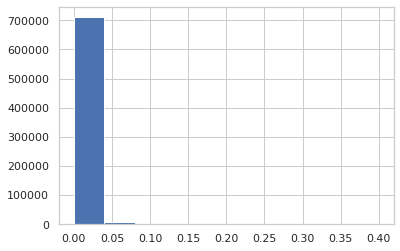

In [23]:
prediccion_202103 = predict_(_2003[seleccionadas].values)
pd.Series(prediccion_202103).hist()

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(_2003[target], prediccion_202103)
print("ROC AUC ::::: ", roc_auc)
print("GINI    ::::: ", roc_auc*2 - 1)

ROC AUC :::::  0.5975960909055619
GINI    :::::  0.19519218181112374


In [33]:
prediccion_202103[prediccion_202103 >= 0.5].shape, prediccion_202103.max()

((0,), 0.39940962195396423)

## >> 202104

<AxesSubplot:>

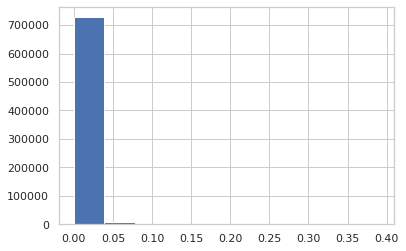

In [34]:
prediccion_202104 = predict_(_2004[seleccionadas].values)
pd.Series(prediccion_202104).hist()

In [35]:
prediccion_202104[prediccion_202104 > 0.5].shape, prediccion_202104.max()

((0,), 0.389301061630249)

In [37]:
roc_auc = roc_auc_score(_2004[target], prediccion_202104)
print("ROC AUC ::::: ", roc_auc)
print("GINI    ::::: ", roc_auc*2 - 1)

ROC AUC :::::  0.6036633281089517
GINI    :::::  0.20732665621790347


## >> 202105

<AxesSubplot:>

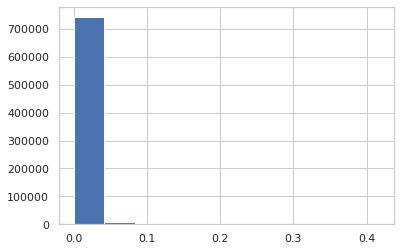

In [38]:
prediccion_202105 = predict_(_2005[seleccionadas].values)
pd.Series(prediccion_202105).hist()

In [39]:
prediccion_202105[prediccion_202105 > 0.5].shape, prediccion_202105.max()

((0,), 0.4160793721675873)

## >> 202106

<AxesSubplot:>

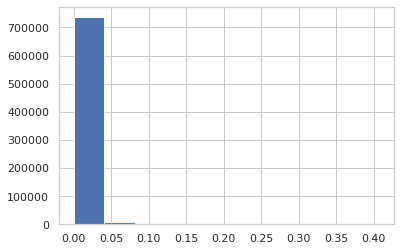

In [40]:
prediccion_202106 = predict_(_2006[seleccionadas].values)
pd.Series(prediccion_202106).hist()

In [41]:
prediccion_202106[prediccion_202106 > 0.5].shape, prediccion_202106.max()

((0,), 0.4059714674949646)

### SAVE

In [43]:
_2003['target'] = prediccion_202103
_2003.to_csv(uri_validation_202103.replace('seguimiento', 'prediccion'), index=False)

In [44]:
_2004['target'] = prediccion_202104
_2004.to_csv(uri_validation_202104.replace('seguimiento', 'prediccion'), index=False)

In [45]:
_2005['target'] = prediccion_202105
_2005.to_csv(uri_validation_202105.replace('seguimiento', 'prediccion'), index=False)

In [46]:
_2006['target'] = prediccion_202106
_2006.to_csv(uri_validation_202106.replace('seguimiento', 'prediccion'), index=False)

In [47]:
del _2003
del _2004
del _2005
del _2006

### Eliminación de Deploy (!IMPORTANTE)

In [48]:
try:
    model_predictor.delete_model()
except Exception as e:
    print(str(e))

Deleting model with name: xgboost-vpc-7-2021-08-02-19-04-05-828


In [49]:
try:
    model_predictor.delete_endpoint()
except Esception as e:
    print(str(e))

Deleting endpoint configuration with name: xgboost-vpc-7-2021-08-02-19-04-05-828
Deleting endpoint with name: xgboost-vpc-7-2021-08-02-19-04-05-828


#### En caso de error o olvido , dirigirese al panel izquierdo de la interfaz de Sage Maker , ingresar a la sección de Inferencia e liminar el modelo y punto de enlace de manera manual en la subsecciones correspondientes.  (Hacer esto en caso no se desea dejar una maquina encendida 24 *7 con el modelo activo)